# i. Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## To Display all columns
pd.set_option('display.max_columns', 500)
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.svm import LinearSVR as LSVR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score, mean_absolute_error
from time import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ii. load the data

In [2]:
seattle_listings = pd.read_csv('seattle/listings.csv')

# iii. Remove data removed in Understanding.ipynb

In [3]:
seattle_listings.drop(columns = ['license','square_feet','requires_license',
                                 'experiences_offered',
                                 'city','jurisdiction_names','state',
                                 'market','smart_location',
                                'country_code','country',
                                'scrape_id','last_scraped','calendar_last_scraped'],inplace=True)

 # 3. Prepare Data 

 First we will analyze the listings data and specifically try to predict prices.
 
 We will analyze the types of the attirbutes

In [4]:
seattle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 78 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498 non-null object
host_id                             3818 non-null int64
host_url                            3818 non-null object
host_name                           3816

For now we will drop the descriptive attributes and leave only the categorical and numerical features.
Will also drop urls for images and listing.

In [5]:
seattle_listings_n = seattle_listings.drop(columns = ['listing_url','name', 'summary','space','description',
                                                     'neighborhood_overview','notes','transit','thumbnail_url',
                                                     'medium_url', 'picture_url', 'xl_picture_url', 'host_url',
                                                     'host_about','host_thumbnail_url','host_picture_url',
                                                     'host_name','host_id','id','host_neighbourhood'])

In [6]:
seattle_listings_n.head()

,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2011-08-11,"Seattle, Washington, United States",within a few hours,96%,100%,f,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,2013-02-21,"Seattle, Washington, United States",within an hour,98%,100%,t,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,2014-06-12,"Seattle, Washington, United States",within a few hours,67%,100%,f,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,"West Lee Street, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.629724,-122.369483,t,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,t,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"8th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.638473,-122.369279,t,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",$100.00,$650.00,"$2,300.00",NaN,NaN,1,$0.00,1,1125,6 months ago,t,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,2011-11-29,"Seattle, Washington, United States",within an hour,100%,NaN,f,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"14th Ave W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,98119,47.632918,-122.372471,t,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,NaN,NaN,$700.00,$125.00,6,$15.00,1,1125,7 weeks ago,t,30,60,90,365,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


We again take another look at the attributes.
First I want to analyze host_location and make sure it has some variance

In [7]:
seattle_listings_n.host_location.notna().sum()/seattle_listings_n.shape[0]

0.997904662126768

In [8]:
seattle_listings_n.host_location.value_counts()/seattle_listings_n.shape[0]

Seattle, Washington, United States                             0.853588
US                                                             0.064432
Spokane, Washington, United States                             0.010739
Kent, Washington, United States                                0.008905
Los Angeles, California, United States                         0.003405
Bellevue, Washington, United States                            0.003143
San Francisco, California, United States                       0.002881
Mercer Island, Washington, United States                       0.002619
Kirkland, Washington, United States                            0.002095
New York, New York, United States                              0.001572
Sammamish, Washington, United States                           0.001310
Seattle                                                        0.001310
Shoreline, Washington, United States                           0.001310
Vashon, Washington, United States                              0

Since there is 86% from Seattle and 6% from US which can be treated as missing info. 
I decided to let go of this feature

In [9]:
seattle_listings_n.drop(columns= ['host_location'],inplace=True)

Next I look at street and see the occurences of the values

In [10]:
seattle_listings_n.street.notna().sum()/seattle_listings_n.shape[0]

1.0

In [11]:
seattle_listings_n.street.value_counts()/seattle_listings_n.shape[0]*100

1st Avenue, Seattle, WA 98101, United States                        0.785752
Hubbell Place, Seattle, WA 98101, United States                     0.759560
12th Avenue East, Seattle, WA 98102, United States                  0.759560
10th Avenue East, Seattle, WA 98102, United States                  0.733368
East Denny Way, Seattle, WA 98122, United States                    0.733368
1st Avenue, Seattle, WA 98121, United States                        0.654793
Boylston Avenue East, Seattle, WA 98102, United States              0.576218
Queen Anne Avenue North, Seattle, WA 98109, United States           0.576218
Summit Avenue East, Seattle, WA 98102, United States                0.550026
2nd Avenue, Seattle, WA 98121, United States                        0.523834
Whitman Avenue North, Seattle, WA 98103, United States              0.523834
11th Avenue Northeast, Seattle, WA 98105, United States             0.497643
13th Avenue East, Seattle, WA 98102, United States                  0.497643

Too many values, postal code and coordinates can be more valuable

In [12]:
seattle_listings_n.drop(columns= ['street'],inplace=True)

Next we take a look at the neighboorhood variables and choose one to leave (neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed)

In [13]:
seattle_listings_n.neighbourhood.value_counts()/seattle_listings_n.shape[0]*100

Capitol Hill                 9.193295
Ballard                      5.578837
Belltown                     5.343112
Minor                        5.028811
Queen Anne                   4.897852
Fremont                      3.876375
Wallingford                  3.745416
University District          2.802514
First Hill                   2.750131
Stevens                      2.566789
North Beacon Hill            2.488214
Lower Queen Anne             2.173913
Central Business District    2.121530
Greenwood                    2.069146
Columbia City                1.597695
Ravenna                      1.545312
Phinney Ridge                1.466737
Magnolia                     1.440545
Green Lake                   1.361970
Atlantic                     1.309586
North Admiral                1.257203
Mount Baker                  1.204819
Leschi                       1.152436
Eastlake                     1.073861
Maple Leaf                   1.073861
Madrona                      1.047669
Pike Place M

In [14]:
seattle_listings_n.neighbourhood_cleansed.value_counts()/seattle_listings_n.shape[0]*100

Broadway                     10.398114
Belltown                      6.128863
Wallingford                   4.374018
Fremont                       4.138292
Minor                         3.535883
University District           3.195390
Stevens                       3.116815
First Hill                    2.828706
Central Business District     2.697748
Lower Queen Anne              2.462022
Greenwood                     2.331063
East Queen Anne               2.147721
North Beacon Hill             2.042954
Phinney Ridge                 1.911996
Adams                         1.833421
Ravenna                       1.754845
Mann                          1.754845
West Queen Anne               1.702462
West Woodland                 1.676270
Columbia City                 1.519120
North Queen Anne              1.414353
Green Lake                    1.414353
Atlantic                      1.388161
Leschi                        1.388161
Loyal Heights                 1.361970
Mount Baker              

In [15]:
seattle_listings_n.neighbourhood_group_cleansed.value_counts()/seattle_listings_n.shape[0]*100

Other neighborhoods    20.796228
Capitol Hill           14.850707
Downtown               13.881613
Central Area            9.664746
Queen Anne              7.726558
Ballard                 6.024096
West Seattle            5.316920
Rainier Valley          4.164484
University District     3.195390
Beacon Hill             3.090623
Cascade                 2.331063
Northgate               2.095338
Delridge                2.069146
Lake City               1.754845
Magnolia                1.597695
Seward Park             1.152436
Interbay                0.288109
Name: neighbourhood_group_cleansed, dtype: float64

Will leave only neighbourhood_group_cleansed as it has a little number of variables to use as categorical variables

In [16]:
seattle_listings_n.drop(columns= ['neighbourhood','neighbourhood_cleansed'],inplace=True)


In [17]:
seattle_listings_n.zipcode.value_counts()/seattle_listings_n.shape[0]*100

98122        11.000524
98103        10.319539
98102         8.878994
98105         5.893138
98109         5.290728
98101         5.264536
98144         5.238345
98121         5.133578
98107         4.714510
98115         4.662127
98112         4.374018
98117         4.295443
98118         4.033525
98119         3.745416
98116         2.933473
98104         2.488214
98125         1.859612
98199         1.728654
98126         1.650079
98106         1.519120
98108         1.466737
98133         1.204819
98136         1.152436
98177         0.497643
98178         0.183342
98134         0.130959
98146         0.130959
99\n98122     0.026192
Name: zipcode, dtype: float64

Next I will transform the data with 't' and 'f' to True and False


In [18]:
tf_cols = ['host_is_superhost','host_has_profile_pic', 'instant_bookable','require_guest_profile_picture',
           'host_identity_verified','is_location_exact','has_availability','require_guest_phone_verification']

In [19]:
for col in tf_cols:
    print(seattle_listings_n[col].isna().sum())
    print(seattle_listings_n[col].notna().sum()/seattle_listings_n.shape[0])
    print(seattle_listings_n[col].value_counts()/seattle_listings_n.shape[0]*100)

2
0.9994761655316919
f    79.570456
t    20.377161
Name: host_is_superhost, dtype: float64
2
0.9994761655316919
t    99.764274
f     0.183342
Name: host_has_profile_pic, dtype: float64
0
1.0
f    84.520691
t    15.479309
Name: instant_bookable, dtype: float64
0
1.0
f    91.592457
t     8.407543
Name: require_guest_profile_picture, dtype: float64
2
0.9994761655316919
t    78.496595
f    21.451021
Name: host_identity_verified, dtype: float64
0
1.0
t    89.36616
f    10.63384
Name: is_location_exact, dtype: float64
0
1.0
t    100.0
Name: has_availability, dtype: float64
0
1.0
f    90.178104
t     9.821896
Name: require_guest_phone_verification, dtype: float64


In [20]:
seattle_listings_n[seattle_listings_n.host_identity_verified.isna()].index

Int64Index([1297, 1419], dtype='int64')

These two rows are filled with NaNs about the host and will be dropped

In [21]:
seattle_listings_n.drop(index = seattle_listings_n[seattle_listings_n.host_identity_verified.isna()].index,inplace=True)

Next we asses the values

In [22]:
for col in tf_cols:
    print(seattle_listings_n[col].isna().sum())
    print(seattle_listings_n[col].notna().sum()/seattle_listings_n.shape[0])
    print(seattle_listings_n[col].value_counts()/seattle_listings_n.shape[0]*100)

0
1.0
f    79.612159
t    20.387841
Name: host_is_superhost, dtype: float64
0
1.0
t    99.816562
f     0.183438
Name: host_has_profile_pic, dtype: float64
0
1.0
f    84.512579
t    15.487421
Name: instant_bookable, dtype: float64
0
1.0
f    91.58805
t     8.41195
Name: require_guest_profile_picture, dtype: float64
0
1.0
t    78.537736
f    21.462264
Name: host_identity_verified, dtype: float64
0
1.0
t    89.360587
f    10.639413
Name: is_location_exact, dtype: float64
0
1.0
t    100.0
Name: has_availability, dtype: float64
0
1.0
f    90.172956
t     9.827044
Name: require_guest_phone_verification, dtype: float64


host_has_profile_pic (99.8%) and has_availability (100%) have all true values and thus are better dropped 

In [23]:
seattle_listings_n.drop(columns= ['host_has_profile_pic','has_availability'],inplace=True)

Convert to Booleans

In [24]:
tf_cols = ['host_is_superhost', 'instant_bookable','require_guest_profile_picture',
           'host_identity_verified','is_location_exact','require_guest_phone_verification']
for col in tf_cols:
    seattle_listings_n[col] = seattle_listings_n[col].map({'t':True,'f':False})
    print(seattle_listings_n[col].isna().sum())
    print(seattle_listings_n[col].notna().sum()/seattle_listings_n.shape[0])
    print(seattle_listings_n[col].value_counts()/seattle_listings_n.shape[0]*100)

0
1.0
False    79.612159
True     20.387841
Name: host_is_superhost, dtype: float64
0
1.0
False    84.512579
True     15.487421
Name: instant_bookable, dtype: float64
0
1.0
False    91.58805
True      8.41195
Name: require_guest_profile_picture, dtype: float64
0
1.0
True     78.537736
False    21.462264
Name: host_identity_verified, dtype: float64
0
1.0
True     89.360587
False    10.639413
Name: is_location_exact, dtype: float64
0
1.0
False    90.172956
True      9.827044
Name: require_guest_phone_verification, dtype: float64


In [25]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2011-08-11,within a few hours,96%,100%,False,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",True,Queen Anne,98119,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,moderate,False,False,2,4.07
1,2013-02-21,within an hour,98%,100%,True,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",True,Queen Anne,98119,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,True,True,6,1.48
2,2014-06-12,within a few hours,67%,100%,False,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",True,Queen Anne,98119,47.629724,-122.369483,True,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,False,False,2,1.15
3,2013-11-06,NaN,NaN,NaN,False,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",True,Queen Anne,98119,47.638473,-122.369279,True,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",$100.00,$650.00,"$2,300.00",NaN,NaN,1,$0.00,1,1125,6 months ago,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,flexible,False,False,1,NaN
4,2011-11-29,within an hour,100%,NaN,False,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",True,Queen Anne,98119,47.632918,-122.372471,True,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00,NaN,NaN,$700.00,$125.00,6,$15.00,1,1125,7 weeks ago,30,60,90,365,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,False,strict,False,False,1,0.89


Next amneties and host_verifications both have a list per entry. We analye the occurnces of the values of each value in these lists

In [26]:
seattle_listings_n.host_verifications.notna().sum()/seattle_listings_n.shape[0]

1.0

In [27]:
seattle_listings_n.amenities.notna().sum()/seattle_listings_n.shape[0]

1.0

In [28]:
amenities_d = {}
for row in range(seattle_listings_n.shape[0]):
    for amenity_u in seattle_listings_n.iloc[row]['amenities'][1:-1].split(','):
        amenity = ''.join(e for e in amenity_u if e.isalnum())
        if amenity == '':
            continue
        if amenity not in amenities_d:
            amenities_d[amenity] =1 
            continue
        amenities_d[amenity] += 1

In [29]:
amenities_d

{'TV': 2572,
 'CableTV': 1445,
 'Internet': 2809,
 'WirelessInternet': 3665,
 'AirConditioning': 675,
 'Kitchen': 3421,
 'Heating': 3625,
 'FamilyKidFriendly': 1961,
 'Washer': 2990,
 'Dryer': 2995,
 'FreeParkingonPremises': 2167,
 'BuzzerWirelessIntercom': 538,
 'SmokeDetector': 3280,
 'CarbonMonoxideDetector': 2484,
 'FirstAidKit': 1680,
 'SafetyCard': 726,
 'FireExtinguisher': 2195,
 'Essentials': 3236,
 'PetsAllowed': 472,
 'Petsliveonthisproperty': 883,
 'Dogs': 509,
 'Cats': 382,
 'HotTub': 303,
 'IndoorFireplace': 885,
 'Shampoo': 2669,
 'Breakfast': 291,
 '24HourCheckin': 615,
 'Hangers': 845,
 'HairDryer': 773,
 'Iron': 741,
 'LaptopFriendlyWorkspace': 744,
 'SuitableforEvents': 208,
 'ElevatorinBuilding': 783,
 'LockonBedroomDoor': 100,
 'WheelchairAccessible': 299,
 'Gym': 441,
 'Pool': 159,
 'SmokingAllowed': 82,
 'Otherpets': 51,
 'Doorman': 84,
 'WasherDryer': 2}

In [30]:
host_verifications_d = {}
for row in range(seattle_listings_n.shape[0]):
    for ver_u in seattle_listings_n.iloc[row]['host_verifications'][1:-1].split(','):
        ver = ''.join(e for e in ver_u if e.isalnum())
        if ver == '':
            continue
        if ver not in host_verifications_d:
            host_verifications_d[ver] =1 
            continue
        host_verifications_d[ver] += 1

In [31]:
host_verifications_d 

{'email': 3706,
 'phone': 3791,
 'reviews': 3549,
 'kba': 1816,
 'facebook': 1928,
 'linkedin': 891,
 'jumio': 1289,
 'google': 745,
 'manualoffline': 52,
 'amex': 25,
 'manualonline': 13,
 'sentid': 9,
 'photographer': 4,
 'weibo': 5}

In [32]:
verifications = list(host_verifications_d.keys())
amenties = list(amenities_d.keys())

In [33]:
for ver in verifications:
    seattle_listings_n[ver] = [False]* seattle_listings_n.shape[0]
for amenty in amenties:
    seattle_listings_n[amenty] = [False]* seattle_listings_n.shape[0]  

In [34]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer
0,2011-08-11,within a few hours,96%,100%,False,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",True,Queen Anne,98119,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,moderate,False,False,2,4.07,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2013-02-21,within an hour,98%,100%,True,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",True,Queen Anne,98119,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,True,True,6,1.48,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2014-06-12,within a few hours,67%,100%,False,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",True,Queen Anne,98119,47.629724,-122.369483,True,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,False,False,2,1.15,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-11-06,NaN,NaN,NaN,False,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",True,Queen Anne,98119,47.638473,-122.369279,True,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",

In [35]:
for row in seattle_listings_n.index:
    for amenity_u in seattle_listings_n.loc[row]['amenities'][1:-1].split(','):
        amenity = ''.join(e for e in amenity_u if e.isalnum())
        if amenity == '':
            continue
        seattle_listings_n.loc[row,amenity] = True

In [36]:
for row in seattle_listings_n.index:
    for ver_u in seattle_listings_n.loc[row]['host_verifications'][1:-1].split(','):
        ver = ''.join(e for e in ver_u if e.isalnum())
        if ver == '':
            continue
        seattle_listings_n.loc[row,ver] = True

In [37]:
seattle_listings_n.drop(columns = ['host_verifications','amenities'],inplace=True)

In [38]:
seattle_listings_n.head(50)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer
0,2011-08-11,within a few hours,96%,100%,False,3.0,3.0,True,Queen Anne,98119,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,moderate,False,False,2,4.07,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2013-02-21,within an hour,98%,100%,True,6.0,6.0,True,Queen Anne,98119,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,True,True,6,1.48,True,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2014-06-12,within a few hours,67%,100%,False,2.0,2.0,True,Queen Anne,98119,47.629724,-122.369483,True,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,$975.00,NaN,NaN,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,False,False,2,1.15,True,True,True,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-11-06,NaN,NaN,NaN,False,1.0,1.0,True,Queen Anne,98119,47.638473,-122.369279,True,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,$100.00,$650.00,"$2,300.00",NaN,NaN,1,$0.00,1,1125,6 months ago,0,0,0,143,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,flexible,False,False,1,NaN,True,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,True,True,True,True,True,False,False,True,True,False,True,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2011-11-29,within an hour,100%,NaN,False,2.0,2.0,Tr

Next and the most important part is handling missing data

First we will drop the weekly/monthly price ... and all the price columns as we intend to predict the price using the features only. 

In [39]:
seattle_listings_n.drop(columns = ['weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people'],inplace=True)

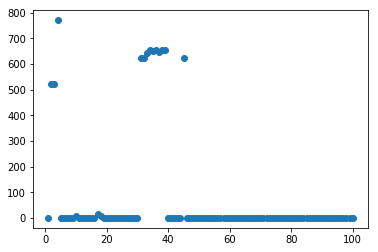

In [40]:
na_counts = seattle_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

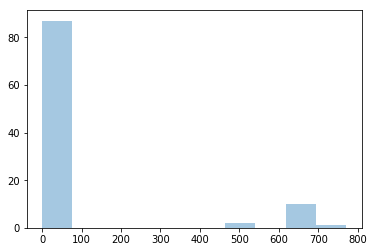

In [41]:
sns.distplot(na_counts.tolist(), kde=False);

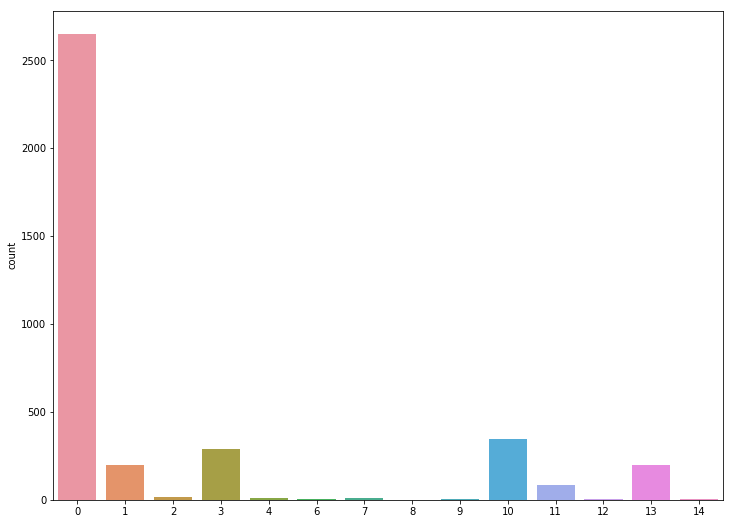

In [42]:
na_row_counts = seattle_listings_n.isna().sum(axis=1)
fig, ax = plt.subplots(figsize=(4*3,3*3))
sns.countplot(na_row_counts,ax=ax);

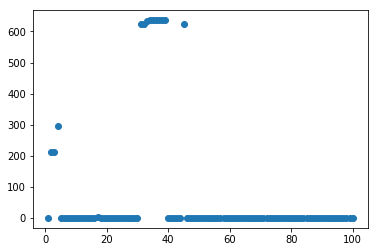

In [48]:
nanful = seattle_listings_n.loc[na_row_counts[na_row_counts>8].index,:]
na_counts = nanful.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

In [51]:
na_counts.sort_values(ascending=False)[:15]

review_scores_value            636
review_scores_location         636
review_scores_communication    636
review_scores_checkin          636
review_scores_cleanliness      636
review_scores_accuracy         636
review_scores_rating           633
reviews_per_month              625
last_review                    625
first_review                   625
host_acceptance_rate           296
host_response_rate             212
host_response_time             212
bathrooms                        4
zipcode                          1
dtype: int64

We find that these rows lack reviews and that can be a useful augmented column

In [58]:
print(nanful.review_scores_value[nanful.review_scores_location.isna()].isna().sum())
print(nanful.review_scores_value[nanful.review_scores_communication.isna()].isna().sum())
print(nanful.reviews_per_month[nanful.review_scores_location.isna()].isna().sum())

636
636
625


We add three new rows for each group of these NaN groups and fill the NaNs with 0

In [60]:
seattle_listings_n['review_scores_missing'] = seattle_listings_n.review_scores_value.isna()
seattle_listings_n['review_scores_rating_missing'] = seattle_listings_n.review_scores_rating.isna()
seattle_listings_n['review_dates_missing'] = seattle_listings_n.reviews_per_month.isna()

In [70]:
seattle_listings_n.review_scores_value.fillna(0,axis=0,inplace=True)
seattle_listings_n.review_scores_location.fillna(0,axis=0,inplace=True)
seattle_listings_n.review_scores_communication.fillna(0,axis=0,inplace=True)
seattle_listings_n.review_scores_checkin.fillna(0,axis=0,inplace=True)
seattle_listings_n.review_scores_cleanliness.fillna(0,axis=0,inplace=True)
seattle_listings_n.review_scores_accuracy.fillna(0,axis=0,inplace=True)
seattle_listings_n.review_scores_rating.fillna(0,axis=0,inplace=True)
seattle_listings_n.reviews_per_month.fillna(0,axis=0,inplace=True)
seattle_listings_n.last_review.fillna(seattle_listings_n.last_review[seattle_listings_n.last_review.notna()].min(),axis=0,inplace=True)
seattle_listings_n.first_review.fillna(seattle_listings_n.first_review[seattle_listings_n.first_review.notna()].min(),axis=0,inplace=True)

After looking at the columns again and there distribution we find 3 columns that are outliers 

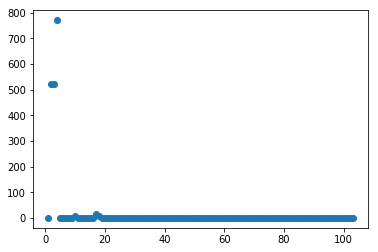

In [75]:
na_counts = seattle_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

In [76]:
na_counts[na_counts>100]

host_response_time      521
host_response_rate      521
host_acceptance_rate    771
dtype: int64

I do not intend to remove these values, this NaN may have a meaning that I missing, I will then impute them with the mean/mode and add a coumn of boolean set to one for NaN values. 

But First we need to preprocess these three columns before handling their NaNs, after which I will get back to study the rest of the NaN Values.

In [77]:
cols_to_process = ['host_acceptance_rate','host_response_rate']
def perc_to_num(x):
    if pd.isna(x):
        return np.nan
    else:
        return int(x[:-1])
for col in cols_to_process:
    seattle_listings_n[col] = seattle_listings_n[col].apply(perc_to_num)

In [78]:
def time_to_dummy(x):
    d = {'within an hour': 0, 'within a few hours': 1 ,"within a day" : 2,'a few days or more':3}
    if pd.isna(x):
        return np.nan
    else:
        return d[x]
seattle_listings_n['host_response_time'] = seattle_listings_n['host_response_time'].apply(time_to_dummy)

In [79]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer,review_scores_missing,review_scores_rating_missing,review_dates_missing
0,2011-08-11,1.0,96.0,100.0,False,3.0,3.0,True,Queen Anne,98119,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$85.00,2,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,moderate,False,False,2,4.07,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2013-02-21,0.0,98.0,100.0,True,6.0,6.0,True,Queen Anne,98119,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$150.00,1,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,True,True,6,1.48,True,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2014-06-12,1.0,67.0,100.0,False,2.0,2.0,True,Queen Anne,98119,47.629724,-122.369483,True,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,$975.00,10,4,30,5 weeks ago,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,False,False,2,1.15,True,True,True,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-11-06,NaN,NaN,NaN,False,1.0,1.0,True,Queen Anne,98119,47.638473,-122.369279,True,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,$100.00,1,1,1125,6 months ago,0,0,0,143,0,2009-06-07,2011-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,flexible,False,False,1,0.00,True,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,True,True,True,True,True,False,False,True,True,False,True,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True
4,2011-11-29,0.0,100.0,NaN,False,2.0,2.0,True,Queen Anne,98119,47.632918,-122.372471,True,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,$45

In [80]:
seattle_listings_n[['host_response_time','host_response_rate','host_acceptance_rate']][seattle_listings_n.host_response_time.isna()].isna().sum()

host_response_time      521
host_response_rate      521
host_acceptance_rate    503
dtype: int64

host_response_time and host_response_rate both have NaNs together all the time.

In [81]:
seattle_listings_n['host_response_missing'] = seattle_listings_n.host_response_time.isna()

In [82]:
seattle_listings_n['host_acceptance_missing'] = seattle_listings_n.host_acceptance_rate.isna()

In [83]:
seattle_listings_n.host_response_rate.fillna(seattle_listings_n.host_response_rate.mean(),axis=0,inplace=True)
seattle_listings_n.host_acceptance_rate.fillna(seattle_listings_n.host_acceptance_rate.mean(),axis=0,inplace=True)
seattle_listings_n.host_response_time.fillna(seattle_listings_n.host_response_time.mode()[0],axis=0,inplace=True)

Now back to observing NaNs

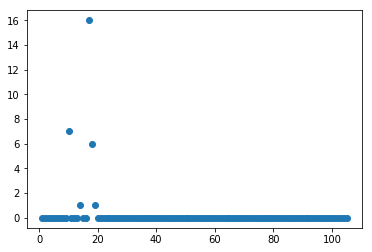

In [84]:
na_counts = seattle_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

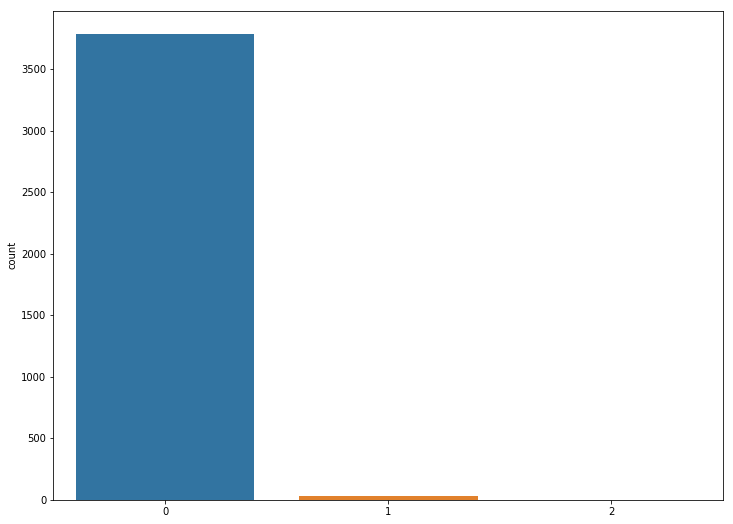

In [85]:
na_row_counts = seattle_listings_n.isna().sum(axis=1)
fig, ax = plt.subplots(figsize=(4*3,3*3))
sns.countplot(na_row_counts,ax=ax);

The values of NaNs are negligibale and thus we can just drop all the rows that have nans

In [86]:
seattle_listings_n.drop(index = na_row_counts[na_row_counts>0].index,inplace=True)

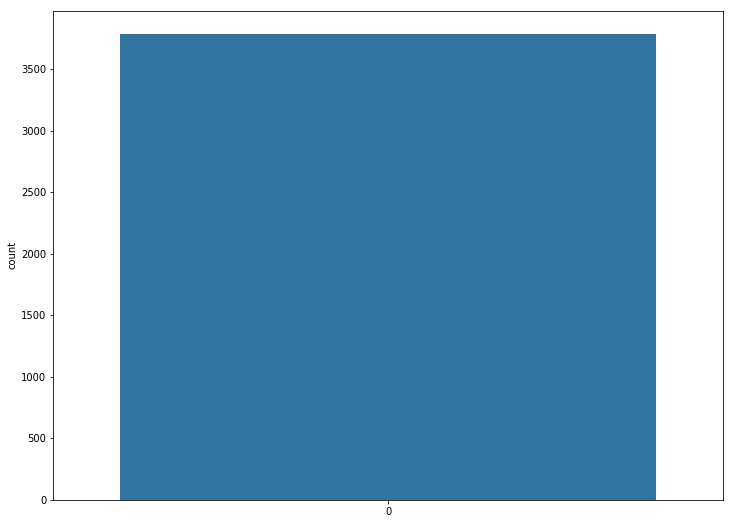

In [87]:
na_row_counts = seattle_listings_n.isna().sum(axis=1)
fig, ax = plt.subplots(figsize=(4*3,3*3))
sns.countplot(na_row_counts,ax=ax);

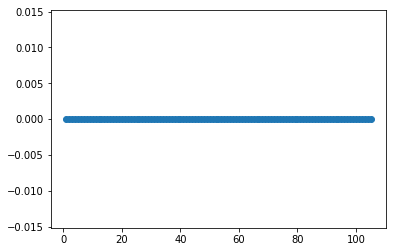

In [88]:
na_counts = seattle_listings_n.isna().sum(axis=0)
plt.scatter(list(range(1,len(na_counts)+1)),na_counts.tolist());

In [89]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing,host_acceptance_missing
0,2011-08-11,1.0,96.000000,100.000000,False,3.0,3.0,True,Queen Anne,98119,47.636289,-122.371025,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$85.00,2,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,moderate,False,False,2,4.07,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2013-02-21,0.0,98.000000,100.000000,True,6.0,6.0,True,Queen Anne,98119,47.639123,-122.365666,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,$150.00,1,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,True,True,6,1.48,True,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2014-06-12,1.0,67.000000,100.000000,False,2.0,2.0,True,Queen Anne,98119,47.629724,-122.369483,True,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,$975.00,10,4,30,5 weeks ago,1,6,17,220,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,False,strict,False,False,2,1.15,True,True,True,False,False,False,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-11-06,0.0,94.886798,99.967159,False,1.0,1.0,True,Queen Anne,98119,47.638473,-122.369279,True,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,$100.00,1,1,1125,6 months ago,0,0,0,143,0,2009-06-07,2011-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,flexible,False,False,1,0.00,True,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,True,True,True,True,True,False,False,True,True,False,True,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
4,20

In [90]:
object_cols = seattle_listings_n.columns[seattle_listings_n.dtypes == 'object']
object_cols

Index(['host_since', 'neighbourhood_group_cleansed', 'zipcode',
       'property_type', 'room_type', 'bed_type', 'price', 'calendar_updated',
       'first_review', 'last_review', 'cancellation_policy'],
      dtype='object')

In [91]:
dates_cols = ['host_since','first_review','last_review']
categoricals = ['neighbourhood_group_cleansed','property_type','bed_type','room_type','cancellation_policy']

In [92]:
for col in categoricals:
    print(seattle_listings_n[col].value_counts())

Other neighborhoods    791
Capitol Hill           560
Downtown               520
Central Area           368
Queen Anne             294
Ballard                229
West Seattle           202
Rainier Valley         157
University District    122
Beacon Hill            117
Cascade                 89
Delridge                79
Northgate               76
Lake City               67
Magnolia                61
Seward Park             44
Interbay                10
Name: neighbourhood_group_cleansed, dtype: int64
House              1720
Apartment          1694
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      36
Cabin                21
Other                21
Bungalow             13
Camper/RV            13
Boat                  7
Tent                  5
Treehouse             3
Dorm                  2
Chalet                1
Yurt                  1
Name: property_type, dtype: int64
Real Bed         3626
Futon              74
Pull-out Sofa      46
Airbed  

In [93]:
dict(seattle_listings_n.property_type.value_counts())

{'House': 1720,
 'Apartment': 1694,
 'Townhouse': 118,
 'Condominium': 91,
 'Loft': 40,
 'Bed & Breakfast': 36,
 'Cabin': 21,
 'Other': 21,
 'Bungalow': 13,
 'Camper/RV': 13,
 'Boat': 7,
 'Tent': 5,
 'Treehouse': 3,
 'Dorm': 2,
 'Chalet': 1,
 'Yurt': 1}

Next we convert the categorical data to dummy variables. but first we will reduce the property type that is >= 10 to others.

In [94]:
d = dict(seattle_listings_n.property_type.value_counts())
seattle_listings_n.property_type = seattle_listings_n.property_type.map(lambda x: x if d[x]> 10 else 'Other')

In [95]:
for feature in categoricals:
    dummies = pd.get_dummies(seattle_listings_n[feature],prefix = feature)
    seattle_listings_n[dummies.columns] = dummies
    seattle_listings_n.drop(feature,axis=1,inplace=True)

In [96]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing,host_acceptance_missing,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,2011-08-11,1.0,96.000000,100.000000,False,3.0,3.0,True,98119,47.636289,-122.371025,True,4,1.0,1.0,1.0,$85.00,2,1,365,4 weeks ago,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,False,False,2,4.07,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,2013-02-21,0.0,98.000000,100.000000,True,6.0,6.0,True,98119,47.639123,-122.365666,True,4,1.0,1.0,1.0,$150.00,1,2,90,today,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,True,True,6,1.48,True,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,2014-06-12,1.0,67.000000,100.000000,False,2.0,2.0,True,98119,47.629724,-122.369483,True,11,4.5,5

WHat is left are the columns with dats and zipcode, calendar_updated and price to be handled. 

In [97]:
seattle_listings_n.zipcode.value_counts()

98122        420
98103        392
98102        335
98105        225
98109        202
98144        199
98101        199
98121        189
98107        180
98115        175
98112        166
98117        163
98118        152
98119        143
98116        112
98104         95
98125         71
98199         66
98126         63
98106         58
98108         56
98133         45
98136         43
98177         19
98178          7
98134          5
98146          5
99\n98122      1
Name: zipcode, dtype: int64

Looks like 99\n98122 entry is wrong and meant to be 98122

In [98]:
ind = seattle_listings_n.zipcode[seattle_listings_n.zipcode == '99\n98122'].index
seattle_listings_n.loc[ind,'zipcode'] = '98122'

In [99]:
seattle_listings_n.zipcode = seattle_listings_n.zipcode.astype(int)
seattle_listings_n.zipcode -= seattle_listings_n.zipcode.min()

In [100]:
seattle_listings_n.zipcode.value_counts()

21    421
2     392
1     335
4     225
8     202
0     199
43    199
20    189
6     180
14    175
11    166
16    163
17    152
18    143
15    112
3      95
24     71
98     66
25     63
5      58
7      56
32     45
35     43
76     19
77      7
33      5
45      5
Name: zipcode, dtype: int64

In [101]:
seattle_listings_n.calendar_updated.value_counts()

today            700
2 weeks ago      344
3 weeks ago      299
2 months ago     274
a week ago       247
yesterday        229
4 weeks ago      213
3 months ago     212
3 days ago       162
5 weeks ago      155
4 days ago       145
4 months ago     133
5 days ago       130
6 weeks ago      118
2 days ago        96
5 months ago      90
7 weeks ago       63
6 days ago        28
6 months ago      27
1 week ago        26
never             24
7 months ago      23
8 months ago      14
10 months ago      8
9 months ago       7
11 months ago      5
12 months ago      5
13 months ago      2
22 months ago      2
16 months ago      1
14 months ago      1
17 months ago      1
30 months ago      1
15 months ago      1
Name: calendar_updated, dtype: int64

In [102]:
def process_update(x):
    if x == 'today':
        return 0 
    if x == 'yesterday':
        return 1
    if x == 'a week ago' or x == '1 week ago':
        return 7
    if x.endswith(' days ago'):
        return int(x[:x.index(' days ago')])
    if x.endswith(' weeks ago'):
        return int(x[:x.index(' weeks ago')])*7
    if x.endswith(' months ago'):
        return int(x[:x.index(' months ago')])*30
    if x =='never':
        return 999999
    else:
        print(x)
        raise ValueError

In [103]:
seattle_listings_n.calendar_updated = seattle_listings_n.calendar_updated.apply(process_update)

In [104]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing,host_acceptance_missing,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,2011-08-11,1.0,96.000000,100.000000,False,3.0,3.0,True,18,47.636289,-122.371025,True,4,1.0,1.0,1.0,$85.00,2,1,365,28,14,41,71,346,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,False,False,2,4.07,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,2013-02-21,0.0,98.000000,100.000000,True,6.0,6.0,True,18,47.639123,-122.365666,True,4,1.0,1.0,1.0,$150.00,1,2,90,0,13,13,16,291,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,True,True,6,1.48,True,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,2014-06-12,1.0,67.000000,100.000000,False,2.0,2.0,True,18,47.629724,-122.369483,True,11,4.5,5.0,7.0,$975.00,10,4,30

In [105]:
seattle_listings_n.shape

(3786, 138)

Next I will process the date features. 
I will convert the dates to the number of days since the first of that respective column

In [106]:
for date_col in dates_cols:
    dates_list = list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),seattle_listings_n[date_col]))
    min_date = min(list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),seattle_listings_n[date_col])))
    seattle_listings_n[date_col] = list(map(lambda x: (x - min_date).days, dates_list))

In [107]:
seattle_listings_n[dates_cols].head()

,host_since,first_review,last_review
0,1004,877,1568
1,1564,1534,1564
2,2040,1879,1447
3,1822,0,0
4,1114,1129,1498


In [108]:
seattle_listings_n.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,zipcode,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,email,phone,reviews,kba,facebook,linkedin,jumio,google,manualoffline,amex,manualonline,sentid,photographer,weibo,TV,CableTV,Internet,WirelessInternet,AirConditioning,Kitchen,Heating,FamilyKidFriendly,Washer,Dryer,FreeParkingonPremises,BuzzerWirelessIntercom,SmokeDetector,CarbonMonoxideDetector,FirstAidKit,SafetyCard,FireExtinguisher,Essentials,PetsAllowed,Petsliveonthisproperty,Dogs,Cats,HotTub,IndoorFireplace,Shampoo,Breakfast,24HourCheckin,Hangers,HairDryer,Iron,LaptopFriendlyWorkspace,SuitableforEvents,ElevatorinBuilding,LockonBedroomDoor,WheelchairAccessible,Gym,Pool,SmokingAllowed,Otherpets,Doorman,WasherDryer,review_scores_missing,review_scores_rating_missing,review_dates_missing,host_response_missing,host_acceptance_missing,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,1004,1.0,96.000000,100.000000,False,3.0,3.0,True,18,47.636289,-122.371025,True,4,1.0,1.0,1.0,$85.00,2,1,365,28,14,41,71,346,207,877,1568,95.0,10.0,10.0,10.0,10.0,9.0,10.0,False,False,False,2,4.07,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,1564,0.0,98.000000,100.000000,True,6.0,6.0,True,18,47.639123,-122.365666,True,4,1.0,1.0,1.0,$150.00,1,2,90,0,13,13,16,291,43,1534,1564,96.0,10.0,10.0,10.0,10.0,10.0,10.0,False,True,True,6,1.48,True,True,True,False,True,True,True,False,False,False,False,False,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
2,2040,1.0,67.000000,100.000000,False,2.0,2.0,True,18,47.629724,-122.369483,True,11,4.5,5.0,7.0,$975.00,10,4,30,35,1,6,17,220,20,1879,1447,97.0,10.0,10.0,

In [109]:
s_listings_features_cols = seattle_listings_n.columns.tolist()
s_listings_features_cols.pop(s_listings_features_cols.index('price'));

In [110]:
s_listings_features = seattle_listings_n[s_listings_features_cols]
s_listings_labels = seattle_listings_n['price'].map(lambda x: float(''.join(e for e in x if e.isalnum()))/100) ## from $## to ## 

In [111]:
Y = s_listings_labels.to_numpy()
print(Y.shape)

(3786,)


In [112]:
X = s_listings_features.to_numpy(dtype = np.float64)
print(X.shape)

(3786, 137)


Now we have all the data ready for classification. 
We will split into train/test sets and try different classifiers. 

Since 132 is a huge number of features I will attempt to use PCA 

In [113]:
scalar = StandardScaler()
pca = PCA()
XPca = pca.fit_transform(scalar.fit_transform(X))

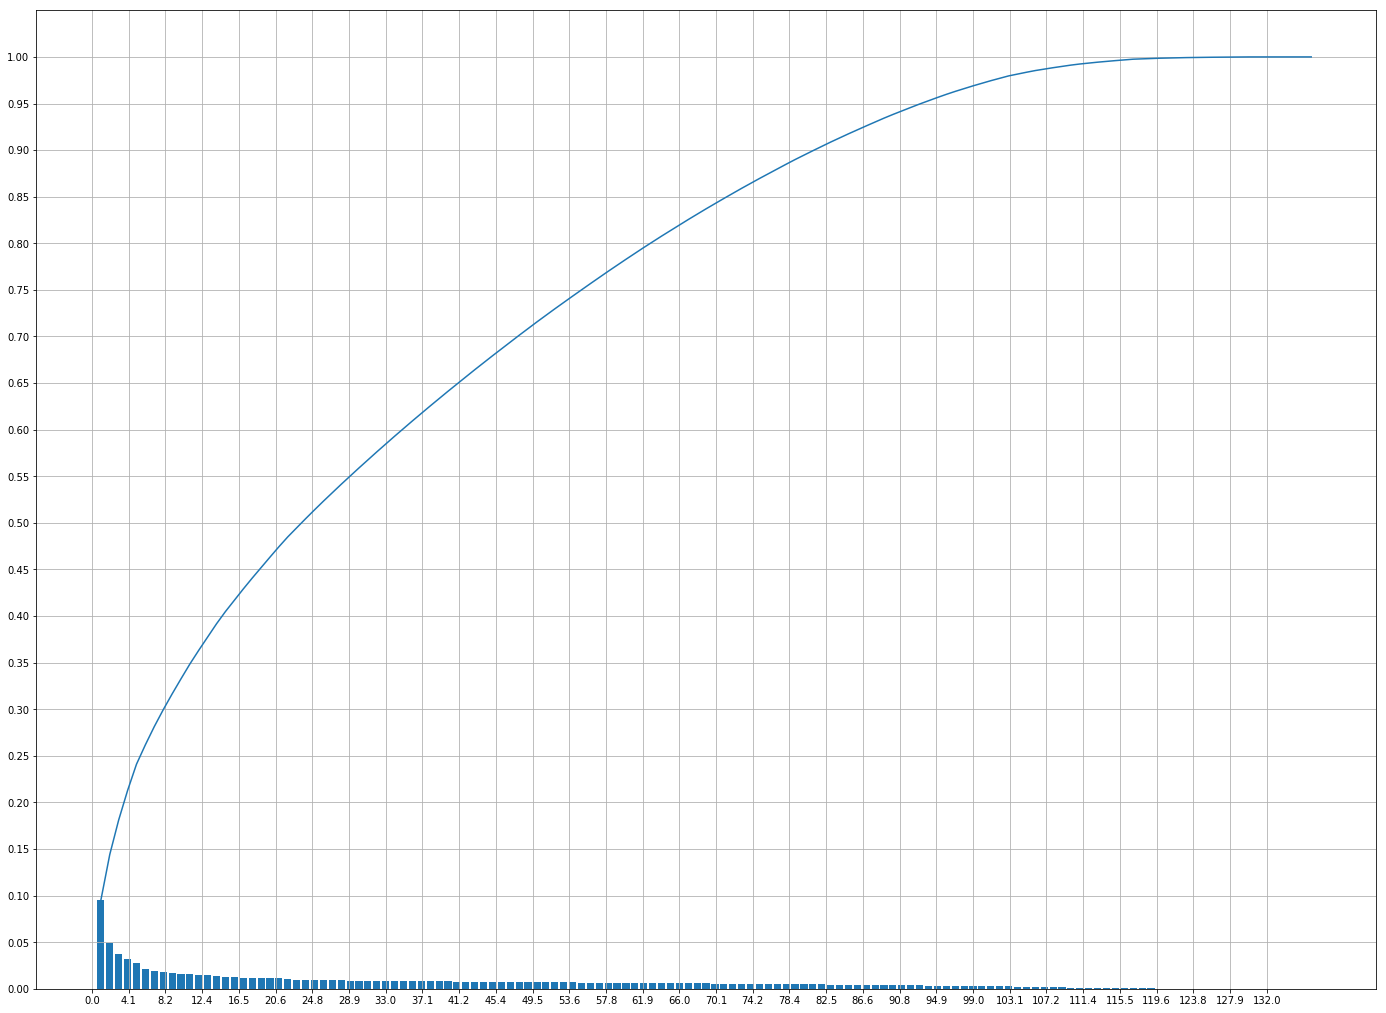

In [114]:
# Investigate the variance accounted for by each principal component.
ratios = pca.explained_variance_ratio_
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*6,3*6))
ax.bar(list(range(1,len(ratios)+1)),ratios)
ax.plot(list(range(1,len(ratios)+1)),np.cumsum(ratios))
ax.grid(True)
ax.set_yticks(np.linspace(0,1,num=21))
ax.set_xticks(np.linspace(0,132,num=132//4));

We find that to Preserve around 90% of the variance we will take only 83 dimensions

In [115]:
pca = PCA(n_components=83)
XPca = pca.fit_transform(scalar.fit_transform(X))

In [116]:
def comp_weights(index,pca):
    comp = pca.components_[index]
    comp = pd.DataFrame(comp).transpose()
    comp.columns = s_listings_features.columns
    comp.index = ['weights']
    comp = comp.sort_values(by = 'weights', axis =1,ascending=False )
    return comp
comp_weights(0,pca)

,review_scores_rating_missing,review_scores_missing,review_dates_missing,host_acceptance_missing,cancellation_policy_flexible,host_response_missing,host_since,calendar_updated,LockonBedroomDoor,LaptopFriendlyWorkspace,Hangers,24HourCheckin,property_type_Townhouse,neighbourhood_group_cleansed_Cascade,bed_type_Airbed,maximum_nights,host_response_time,bed_type_Couch,property_type_Bed & Breakfast,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_Capitol Hill,HairDryer,room_type_Shared room,Iron,room_type_Private room,property_type_Condominium,WasherDryer,latitude,neighbourhood_group_cleansed_Magnolia,property_type_Other,property_type_Bungalow,neighbourhood_group_cleansed_West Seattle,zipcode,Gym,property_type_Camper/RV,HotTub,neighbourhood_group_cleansed_Lake City,host_total_listings_count,host_listings_count,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Northgate,sentid,bed_type_Pull-out Sofa,bed_type_Futon,ElevatorinBuilding,neighbourhood_group_cleansed_Delridge,manualoffline,neighbourhood_group_cleansed_Interbay,SmokingAllowed,host_acceptance_rate,weibo,bedrooms,minimum_nights,neighbourhood_group_cleansed_Queen Anne,Washer,amex,bathrooms,property_type_Loft,longitude,property_type_Apartment,IndoorFireplace,PetsAllowed,Doorman,Otherpets,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Ballard,calculated_host_listings_count,photographer,manualonline,Dryer,neighbourhood_group_cleansed_Beacon Hill,Breakfast,neighbourhood_group_cleansed_Seward Park,WheelchairAccessible,BuzzerWirelessIntercom,Dogs,AirConditioning,google,Cats,neighbourhood_group_cleansed_Central Area,property_type_House,TV,Pool,beds,bed_type_Real Bed,SuitableforEvents,property_type_Cabin,Petsliveonthisproperty,CableTV,room_type_Entire home/apt,jumio,Kitchen,neighbourhood_group_cleansed_Downtown,linkedin,phone,availability_30,facebook,accommodates,FreeParkingonPremises,SafetyCard,FamilyKidFriendly,availability_365,guests_included,FireExtinguisher,availability_60,Internet,host_response_rate,require_guest_profile_picture,is_location_exact,FirstAidKit,availability_90,CarbonMonoxideDetector,Essentials,require_guest_phone_verification,instant_bookable,SmokeDetector,Heating,cancellation_policy_strict,email,WirelessInternet,Shampoo,cancellation_policy_moderate,kba,host_is_superhost,host_identity_verified,number_of_reviews,reviews_per_month,reviews,first_review,last_review,review_scores_location,review_scores_value,review_scores_cleanliness,review_scores_accuracy,review_scores_checkin,review_scores_rating,review_scores_communication
weights,0.271196,0.271118,0.268575,0.100874,0.090826,0.08872,0.050145,0.045025,0.039199,0.029044,0.025488,0.020614,0.019793,0.015529,0.01463,0.012521,0.012452,0.012213,0.01171,0.010526,0.010369,0.010051,0.00995,0.009694,0.00962,0.008383,0.008296,0.007339,0.006398,0.005532,0.005501,0.004628,0.004383,0.004036,0.003213,0.002609,0.002482,0.002266,0.002266,0.002141,0.001818,0.00155,0.001532,0.001512,0.001358,0.001131,0.000972,0.000906,0.000712,0.000585,0.000408,0.000203,-0.000045,-0.000937,-0.001399,-0.001584,-0.001614,-0.001629,-0.001692,-0.001811,-0.002192,-0.002366,-0.002873,-0.003892,-0.003912,-0.004003,-0.004409,-0.004446,-0.004599,-0.005083,-0.005177,-0.006173,-0.006276,-0.006733,-0.006998,-0.007479,-0.00777,-0.008087,-0.008629,-0.009766,-0.009889,-0.010103,-0.010296,-0.010396,-0.011545,-0.011968,-0.012715,-0.012836,-0.012887,-0.013025,-0.013764,-0.01431,-0.014388,-0.015638,-0.015658,-0.016417,-0.018048,-0.019002,-0.019284,-0.020129,-0.025071,-0.025102,-0.025122,-0.025147,-0.025831,-0.027833,-0.029036,-0.029348,-0.030347,-0.030604,-0.032002,-0.033613,-0.033692,-0.033779,-0.03634,-0.036643,-0.039319,-0.042374,-0.044118,-0.044828,-0.045051,-0.045203,-0.048133,-0.070746,-0.071715,-0.089401,-0.138871,-0.180175,-0.240084,-0.268128,-0.269677,-0.269797,-0.270052,-0.270227,-0.270347,-0.270855,-0.271157


In [117]:
comp_weights(1,pca)

,Iron,HairDryer,Hangers,neighbourhood_group_cleansed_Downtown,24HourCheckin,Gym,ElevatorinBuilding,room_type_Entire home/apt,LaptopFriendlyWorkspace,accommodates,cancellation_policy_strict,host_total_listings_count,host_listings_count,beds,Pool,TV,BuzzerWirelessIntercom,Dryer,FamilyKidFriendly,CableTV,Doorman,Washer,AirConditioning,Kitchen,HotTub,property_type_Apartment,WheelchairAccessible,require_guest_phone_verification,Internet,require_guest_profile_picture,bedrooms,Shampoo,CarbonMonoxideDetector,guests_included,SafetyCard,Essentials,linkedin,bathrooms,FireExtinguisher,SmokeDetector,Heating,WirelessInternet,property_type_Condominium,bed_type_Real Bed,host_identity_verified,instant_bookable,calculated_host_listings_count,jumio,host_response_rate,FirstAidKit,review_dates_missing,review_scores_rating_missing,review_scores_missing,SuitableforEvents,email,amex,maximum_nights,PetsAllowed,availability_90,availability_60,host_is_superhost,facebook,manualonline,manualoffline,availability_30,is_location_exact,kba,property_type_Loft,FreeParkingonPremises,host_acceptance_rate,minimum_nights,reviews,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Interbay,IndoorFireplace,neighbourhood_group_cleansed_Cascade,property_type_Townhouse,photographer,phone,neighbourhood_group_cleansed_Magnolia,WasherDryer,weibo,neighbourhood_group_cleansed_West Seattle,sentid,property_type_Bungalow,neighbourhood_group_cleansed_University District,google,bed_type_Couch,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_Northgate,LockonBedroomDoor,reviews_per_month,review_scores_cleanliness,review_scores_location,number_of_reviews,host_response_time,neighbourhood_group_cleansed_Capitol Hill,bed_type_Pull-out Sofa,neighbourhood_group_cleansed_Delridge,last_review,availability_365,property_type_Cabin,first_review,neighbourhood_group_cleansed_Ballard,SmokingAllowed,review_scores_rating,bed_type_Airbed,review_scores_accuracy,property_type_Camper/RV,review_scores_communication,neighbourhood_group_cleansed_Lake City,review_scores_checkin,Otherpets,property_type_Other,latitude,review_scores_value,property_type_Bed & Breakfast,calendar_updated,room_type_Shared room,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Beacon Hill,longitude,host_since,zipcode,neighbourhood_group_cleansed_Rainier Valley,Breakfast,bed_type_Futon,neighbourhood_group_cleansed_Other neighborhoods,cancellation_policy_moderate,Cats,Dogs,host_response_missing,host_acceptance_missing,Petsliveonthisproperty,cancellation_policy_flexible,property_type_House,room_type_Private room
weights,0.223957,0.222238,0.216803,0.20315,0.201106,0.196157,0.190436,0.1901,0.189994,0.180877,0.161411,0.158798,0.158798,0.151008,0.148202,0.146263,0.135276,0.134997,0.134973,0.13382,0.132599,0.132156,0.129808,0.122136,0.111832,0.109017,0.108901,0.107018,0.106222,0.106173,0.106173,0.10382,0.098728,0.094144,0.093306,0.093215,0.086561,0.086192,0.085047,0.081172,0.078785,0.067896,0.065003,0.057571,0.045596,0.039137,0.039123,0.030039,0.029923,0.027906,0.026359,0.025874,0.025401,0.023687,0.021799,0.021633,0.019518,0.018496,0.016365,0.016115,0.016102,0.015757,0.013433,0.013226,0.013019,0.011295,0.007724,0.006766,0.005864,0.005689,0.004456,0.003454,0.002568,0.000716,0.000174,0.000048,-0.000289,-0.001951,-0.003568,-0.003642,-0.004287,-0.007761,-0.007762,-0.008042,-0.008635,-0.009885,-0.011399,-0.011658,-0.012789,-0.014832,-0.014909,-0.015651,-0.019056,-0.019488,-0.020484,-0.020909,-0.020915,-0.020969,-0.021225,-0.021461,-0.021587,-0.021772,-0.023305,-0.023438,-0.024118,-0.024395,-0.024692,-0.025246,-0.026029,-0.026058,-0.026852,-0.027296,-0.0273,-0.027765,-0.028295,-0.02905,-0.029239,-0.030684,-0.031424,-0.032388,-0.03254,-0.035729,-0.036232,-0.038702,-0.040062,-0.043436,-0.047137,-0.050326,-0.058472,-0.061676,-0.06333,-0.065156,-0.068026,-0.099464,-0.109971,-0.111432,-0.183233


In [118]:
comp_weights(2,pca)

,bedrooms,accommodates,beds,property_type_House,bathrooms,guests_included,FreeParkingonPremises,IndoorFireplace,FamilyKidFriendly,FireExtinguisher,zipcode,neighbourhood_group_cleansed_Other neighborhoods,CableTV,PetsAllowed,TV,FirstAidKit,room_type_Entire home/apt,Dryer,Washer,SmokeDetector,bed_type_Real Bed,Petsliveonthisproperty,Heating,neighbourhood_group_cleansed_West Seattle,WirelessInternet,host_acceptance_missing,CarbonMonoxideDetector,is_location_exact,neighbourhood_group_cleansed_Magnolia,kba,neighbourhood_group_cleansed_Central Area,Dogs,Kitchen,Internet,SuitableforEvents,latitude,host_response_missing,cancellation_policy_strict,neighbourhood_group_cleansed_Ballard,property_type_Townhouse,Cats,SafetyCard,host_response_rate,neighbourhood_group_cleansed_Rainier Valley,Otherpets,neighbourhood_group_cleansed_Seward Park,host_acceptance_rate,neighbourhood_group_cleansed_Northgate,Shampoo,neighbourhood_group_cleansed_Beacon Hill,cancellation_policy_moderate,Essentials,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Queen Anne,review_scores_missing,neighbourhood_group_cleansed_Delridge,review_scores_rating_missing,review_dates_missing,host_is_superhost,email,WasherDryer,SmokingAllowed,host_response_time,google,review_scores_value,review_scores_rating,weibo,manualonline,review_scores_checkin,minimum_nights,review_scores_accuracy,property_type_Bungalow,review_scores_cleanliness,photographer,review_scores_communication,neighbourhood_group_cleansed_Interbay,amex,property_type_Cabin,host_identity_verified,facebook,Breakfast,property_type_Bed & Breakfast,LockonBedroomDoor,last_review,review_scores_location,phone,first_review,property_type_Camper/RV,property_type_Other,property_type_Loft,sentid,maximum_nights,linkedin,instant_bookable,reviews,host_since,manualoffline,bed_type_Airbed,bed_type_Couch,longitude,neighbourhood_group_cleansed_Cascade,AirConditioning,HotTub,property_type_Condominium,LaptopFriendlyWorkspace,neighbourhood_group_cleansed_University District,calendar_updated,bed_type_Futon,bed_type_Pull-out Sofa,24HourCheckin,number_of_reviews,require_guest_phone_verification,cancellation_policy_flexible,jumio,require_guest_profile_picture,Iron,HairDryer,Hangers,availability_365,room_type_Private room,neighbourhood_group_cleansed_Capitol Hill,calculated_host_listings_count,room_type_Shared room,host_total_listings_count,host_listings_count,WheelchairAccessible,reviews_per_month,Doorman,Pool,availability_30,availability_60,availability_90,BuzzerWirelessIntercom,Gym,neighbourhood_group_cleansed_Downtown,ElevatorinBuilding,property_type_Apartment
weights,0.326809,0.290759,0.287687,0.244295,0.238349,0.224158,0.186632,0.172919,0.169193,0.098566,0.094255,0.09282,0.091497,0.089147,0.088456,0.085554,0.085042,0.083139,0.081048,0.074149,0.069485,0.067449,0.065419,0.064659,0.062112,0.058002,0.056848,0.054518,0.054321,0.052966,0.052417,0.051244,0.04945,0.047755,0.043748,0.042918,0.041712,0.037637,0.035321,0.034935,0.03469,0.032455,0.028307,0.026857,0.026368,0.021904,0.018604,0.016199,0.013556,0.012622,0.010973,0.010889,0.00998,0.009589,0.008818,0.008447,0.008135,0.007208,0.005592,0.005565,0.003456,0.000474,0.000389,-0.000969,-0.002083,-0.002304,-0.00231,-0.002394,-0.003395,-0.003403,-0.00434,-0.004612,-0.004646,-0.004873,-0.0054,-0.007507,-0.007996,-0.009413,-0.009664,-0.010631,-0.011573,-0.011613,-0.011823,-0.013875,-0.014152,-0.016641,-0.016918,-0.017501,-0.017693,-0.018695,-0.019199,-0.019855,-0.021674,-0.022425,-0.022989,-0.024895,-0.024908,-0.025594,-0.026901,-0.028788,-0.028935,-0.031668,-0.032071,-0.033404,-0.034721,-0.038778,-0.039198,-0.039625,-0.043508,-0.043556,-0.044607,-0.047752,-0.050819,-0.051929,-0.05375,-0.054124,-0.054864,-0.055536,-0.059779,-0.060002,-0.062875,-0.066012,-0.072436,-0.072673,-0.072673,-0.074459,-0.077766,-0.089112,-0.096889,-0.104835,-0.11299,-0.114838,-0.141279,-0.145019,-0.192795,-0.211055,-0.232792


In [119]:
comp_weights(3,pca)

,Hangers,LaptopFriendlyWorkspace,HairDryer,Iron,24HourCheckin,room_type_Private room,availability_90,FirstAidKit,availability_60,availability_30,FireExtinguisher,Shampoo,reviews_per_month,Petsliveonthisproperty,LockonBedroomDoor,property_type_House,Essentials,SmokeDetector,number_of_reviews,host_response_rate,CarbonMonoxideDetector,Breakfast,SafetyCard,host_is_superhost,Cats,Dogs,availability_365,Heating,instant_bookable,FreeParkingonPremises,WirelessInternet,cancellation_policy_moderate,property_type_Townhouse,neighbourhood_group_cleansed_Rainier Valley,property_type_Bed & Breakfast,google,zipcode,kba,is_location_exact,host_since,phone,host_identity_verified,neighbourhood_group_cleansed_Lake City,SmokingAllowed,Internet,review_dates_missing,neighbourhood_group_cleansed_Beacon Hill,review_scores_missing,bed_type_Pull-out Sofa,neighbourhood_group_cleansed_Central Area,review_scores_rating_missing,IndoorFireplace,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Other neighborhoods,Otherpets,longitude,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Seward Park,email,neighbourhood_group_cleansed_West Seattle,amex,property_type_Loft,property_type_Cabin,neighbourhood_group_cleansed_Magnolia,bed_type_Airbed,weibo,neighbourhood_group_cleansed_Interbay,property_type_Bungalow,linkedin,neighbourhood_group_cleansed_Northgate,bed_type_Futon,photographer,host_acceptance_rate,manualoffline,sentid,cancellation_policy_flexible,manualonline,property_type_Camper/RV,PetsAllowed,bed_type_Couch,SuitableforEvents,facebook,room_type_Shared room,property_type_Other,latitude,AirConditioning,property_type_Condominium,require_guest_profile_picture,require_guest_phone_verification,FamilyKidFriendly,Doorman,calendar_updated,maximum_nights,neighbourhood_group_cleansed_University District,last_review,reviews,TV,review_scores_cleanliness,review_scores_value,minimum_nights,jumio,WasherDryer,review_scores_rating,review_scores_accuracy,review_scores_checkin,guests_included,review_scores_communication,CableTV,bed_type_Real Bed,host_listings_count,host_total_listings_count,first_review,neighbourhood_group_cleansed_Capitol Hill,review_scores_location,Dryer,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Queen Anne,Washer,calculated_host_listings_count,WheelchairAccessible,bathrooms,HotTub,BuzzerWirelessIntercom,cancellation_policy_strict,Kitchen,bedrooms,beds,Pool,host_response_missing,host_acceptance_missing,Gym,host_response_time,accommodates,neighbourhood_group_cleansed_Downtown,ElevatorinBuilding,property_type_Apartment,room_type_Entire home/apt
weights,0.246242,0.244353,0.243417,0.226163,0.219149,0.196273,0.179132,0.179064,0.17322,0.156579,0.154514,0.152978,0.152741,0.138556,0.130409,0.126387,0.124885,0.122516,0.119473,0.117226,0.111886,0.110331,0.109796,0.109346,0.10342,0.101402,0.087304,0.082615,0.080725,0.077097,0.07265,0.068773,0.064304,0.059114,0.057366,0.054177,0.053919,0.051717,0.051244,0.043444,0.042351,0.041391,0.038797,0.038659,0.038583,0.038206,0.036549,0.035216,0.035146,0.035072,0.034431,0.034144,0.034112,0.032419,0.031861,0.029906,0.029805,0.028775,0.026395,0.023914,0.022873,0.021684,0.020155,0.017419,0.016857,0.016314,0.016198,0.013326,0.013289,0.009632,0.008514,0.007194,0.007045,0.006891,0.005699,0.003703,0.001786,-0.000356,-0.001423,-0.001604,-0.001991,-0.002665,-0.00452,-0.007889,-0.009308,-0.009826,-0.01,-0.012649,-0.012649,-0.012752,-0.0137,-0.014278,-0.01559,-0.015711,-0.016344,-0.017016,-0.018135,-0.018745,-0.021058,-0.021456,-0.021916,-0.02242,-0.022435,-0.02338,-0.024597,-0.024928,-0.026251,-0.029166,-0.031582,-0.034211,-0.034211,-0.034502,-0.03575,-0.036177,-0.037812,-0.041153,-0.041963,-0.042163,-0.043984,-0.054147,-0.060504,-0.06313,-0.064287,-0.070411,-0.0719,-0.08679,-0.092705,-0.094594,-0.0948,-0.098593,-0.103164,-0.106199,-0.11043,-0.112366,-0.148664,-0.164521,-0.189627


In [120]:
comp_weights(4,pca)

,availability_60,availability_90,availability_30,availability_365,calculated_host_listings_count,host_total_listings_count,host_listings_count,require_guest_phone_verification,require_guest_profile_picture,cancellation_policy_strict,property_type_House,HotTub,host_response_time,Pool,beds,bathrooms,bedrooms,accommodates,room_type_Private room,room_type_Shared room,SuitableforEvents,FreeParkingonPremises,linkedin,neighbourhood_group_cleansed_Magnolia,zipcode,CableTV,jumio,IndoorFireplace,neighbourhood_group_cleansed_University District,calendar_updated,facebook,FamilyKidFriendly,host_identity_verified,neighbourhood_group_cleansed_Beacon Hill,Gym,reviews,property_type_Other,property_type_Bed & Breakfast,neighbourhood_group_cleansed_West Seattle,AirConditioning,weibo,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Downtown,Breakfast,neighbourhood_group_cleansed_Other neighborhoods,number_of_reviews,bed_type_Real Bed,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_Delridge,property_type_Camper/RV,neighbourhood_group_cleansed_Interbay,email,guests_included,FireExtinguisher,WasherDryer,neighbourhood_group_cleansed_Lake City,Doorman,review_scores_rating_missing,review_dates_missing,review_scores_missing,minimum_nights,sentid,SmokingAllowed,bed_type_Pull-out Sofa,phone,property_type_Bungalow,photographer,property_type_Cabin,Otherpets,bed_type_Airbed,host_acceptance_rate,neighbourhood_group_cleansed_Northgate,Washer,FirstAidKit,Dryer,neighbourhood_group_cleansed_Central Area,maximum_nights,neighbourhood_group_cleansed_Ballard,manualonline,longitude,PetsAllowed,Dogs,LockonBedroomDoor,property_type_Loft,bed_type_Couch,property_type_Townhouse,SafetyCard,last_review,review_scores_checkin,review_scores_communication,review_scores_cleanliness,bed_type_Futon,latitude,review_scores_location,kba,review_scores_rating,review_scores_accuracy,review_scores_value,WirelessInternet,host_is_superhost,Petsliveonthisproperty,manualoffline,property_type_Condominium,WheelchairAccessible,Cats,Heating,amex,neighbourhood_group_cleansed_Cascade,Internet,instant_bookable,Kitchen,ElevatorinBuilding,neighbourhood_group_cleansed_Queen Anne,cancellation_policy_flexible,first_review,BuzzerWirelessIntercom,neighbourhood_group_cleansed_Capitol Hill,google,TV,is_location_exact,reviews_per_month,CarbonMonoxideDetector,cancellation_policy_moderate,host_response_rate,Shampoo,24HourCheckin,SmokeDetector,host_acceptance_missing,Iron,HairDryer,room_type_Entire home/apt,host_response_missing,Essentials,Hangers,property_type_Apartment,LaptopFriendlyWorkspace,host_since
weights,0.356707,0.351681,0.344741,0.293354,0.200773,0.167952,0.167952,0.144364,0.142625,0.138791,0.130691,0.10807,0.106714,0.101209,0.0951,0.094024,0.091518,0.080963,0.07715,0.07649,0.07207,0.062225,0.060303,0.059258,0.05882,0.058022,0.048659,0.045918,0.043816,0.042261,0.039363,0.037293,0.035592,0.03545,0.032148,0.031192,0.028013,0.026584,0.025089,0.024178,0.019255,0.018454,0.018,0.017105,0.016762,0.016538,0.016226,0.014926,0.013895,0.013229,0.01299,0.012987,0.012752,0.011733,0.01154,0.011538,0.010751,0.010541,0.008802,0.008346,0.007318,0.007287,0.004365,0.002968,0.001359,0.000563,-0.000482,-0.001201,-0.00145,-0.002287,-0.003815,-0.004152,-0.005515,-0.005669,-0.006567,-0.007166,-0.007575,-0.009795,-0.009834,-0.009897,-0.010443,-0.011001,-0.01128,-0.012834,-0.014106,-0.01461,-0.015718,-0.017326,-0.01735,-0.018066,-0.018102,-0.018579,-0.018806,-0.018984,-0.019136,-0.02054,-0.020668,-0.021692,-0.02506,-0.031859,-0.034571,-0.035381,-0.036376,-0.036534,-0.038131,-0.039233,-0.041953,-0.042544,-0.049473,-0.052169,-0.052247,-0.052996,-0.058321,-0.060426,-0.061577,-0.062518,-0.06293,-0.06561,-0.066293,-0.070391,-0.07063,-0.080337,-0.083639,-0.083768,-0.084847,-0.089808,-0.091016,-0.09118,-0.100494,-0.102914,-0.103242,-0.110953,-0.115284,-0.115611,-0.124312,-0.130851,-0.155327


## 4. Modeling

In [121]:
X_train, X_test, y_train, y_test = train_test_split(XPca, Y, test_size=500, random_state=555)

I will try SVMs, linear regression, and a GradientBoostedTrees model to get a spectrum of all the types of models.

In [122]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner,X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train,y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first  training samples which is y_train
    results['mae_train'] = mean_absolute_error(y_train,predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['mae_test'] = mean_absolute_error(y_test,predictions_test)
    
    # Compute F-score on training samples using fbeta_score()
    results['r2_train'] = r2_score(y_train,predictions_train)
        
    # Compute F-score on the test set which is y_test
    results['r2_test'] = r2_score(y_test,predictions_test)
       
    # Success
    print("{} trained".format(learner.__class__.__name__))
        
    # Return the results
    return results

In [123]:
import matplotlib.patches as mpatches

def evaluate(results):
    """
    Visualization code to display results of various learners.
    inputs:
      - learners: a list of supervised learners
      - results: a dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 1
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'mae_train', 'r2_train', 'pred_time', 'mae_test', 'r2_test']):
            # Creative plot code
            ax[j//3, j%3].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
#             ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
            ax[j//3, j%3].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("MAE Score")
    ax[0, 2].set_ylabel("R2-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("MAE Score")
    ax[1, 2].set_ylabel("R2-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("MAE Score on Training Subset")
    ax[0, 2].set_title("R2-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("MAE Score on Testing Set")
    ax[1, 2].set_title("R2-score on Testing Set")

    
    # Set y-limits for score panels
#     ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
#     ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [124]:
svr = SVR(gamma='scale')
gbr = GBR()
lr = LR()

SVR trained
GradientBoostingRegressor trained
LinearRegression trained


/home/mmahrous/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


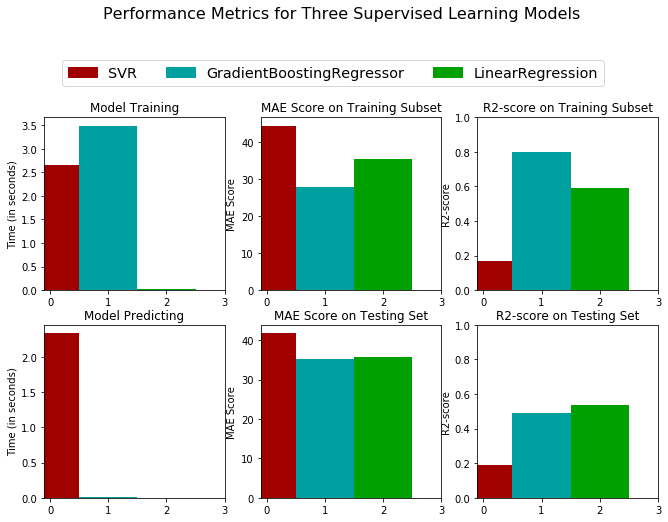

In [125]:
results = {}
for clf in [svr, gbr, lr]:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf,X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

First before making decisions we should give SVR and GBR another chance, the latter is obviously overfitting but it is so close to LR. 

WIll try different SVR kernels 
and grid search on GBR

SVR trained
GradientBoostingRegressor trained
LinearRegression trained


/home/mmahrous/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


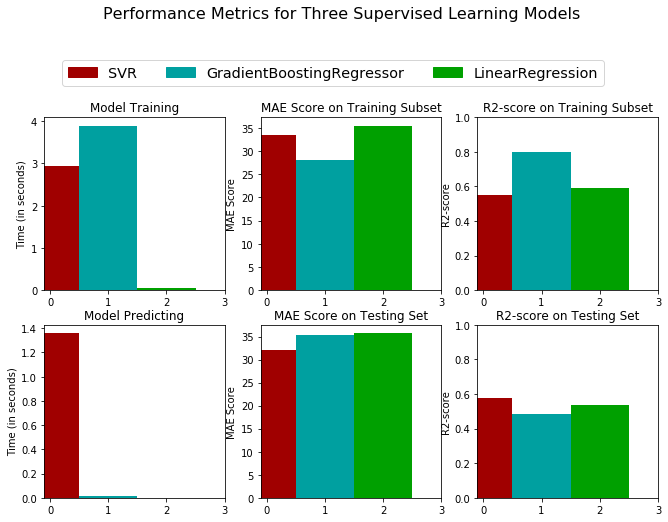

In [126]:
svr = SVR(kernel = 'linear',gamma='scale')
gbr = GBR()
lr = LR()
results = {}
for clf in [svr, gbr, lr]:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf,X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

We find that SVR with a linear kernel beat the other three models. 

SVR trained
GradientBoostingRegressor trained
LinearRegression trained


/home/mmahrous/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


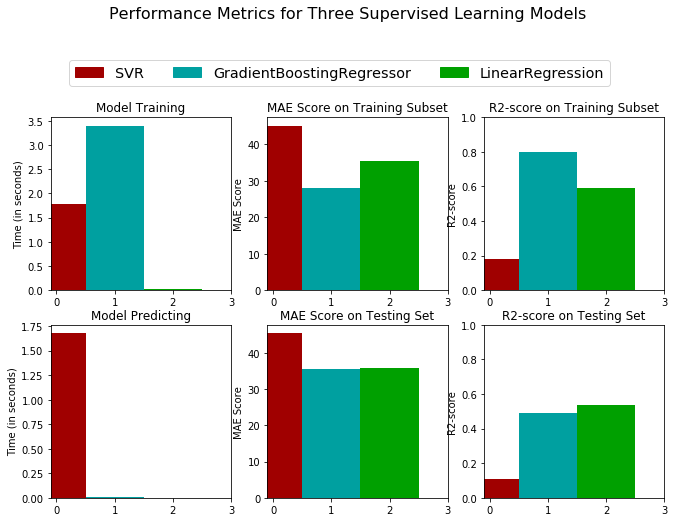

In [127]:
svr = SVR(kernel = 'poly',gamma='scale')
gbr = GBR()
lr = LR()
results = {}
for clf in [svr, gbr, lr]:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf,X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

Also poly kernel is not performing well, which tells us that the data has a linear trend and complexity is not helping us. 

In [128]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# TODO: Initialize the classifier
clf = GBR(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [25, 50, 100, 150, 300,]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf , scoring = scorer, param_grid = parameters,cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("MAE  on testing data: {:.4f}".format(mean_absolute_error(y_test, predictions)))
print("R2-score on testing data: {:.4f}".format(r2_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final MAE score on the testing data: {:.4f}".format(mean_absolute_error(y_test, best_predictions)))
print("Final R2-score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

Unoptimized model
------
MAE  on testing data: 35.2461
R2-score on testing data: 0.4908

Optimized Model
------
Final MAE score on the testing data: 35.1852
Final R2-score on the testing data: 0.4738


Next we will make a tighter searh around the 150 n_estimators

In [129]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# TODO: Initialize the classifier
clf = GBR(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [105, 115, 130, 150, 175]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf , scoring = scorer, param_grid = parameters,cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("MAE  on testing data: {:.4f}".format(mean_absolute_error(y_test, predictions)))
print("R2-score on testing data: {:.4f}".format(r2_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final MAE score on the testing data: {:.4f}".format(mean_absolute_error(y_test, best_predictions)))
print("Final R2-score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

Unoptimized model
------
MAE  on testing data: 35.2461
R2-score on testing data: 0.4908

Optimized Model
------
Final MAE score on the testing data: 35.4638
Final R2-score on the testing data: 0.4793


In [130]:
print(f"Best n_estimators is {best_clf.get_params()['n_estimators']}")

Best n_estimators is 175


Turns out that 150 is the best and we will stop at that. 

SVR trained
GradientBoostingRegressor trained
LinearRegression trained


/home/mmahrous/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


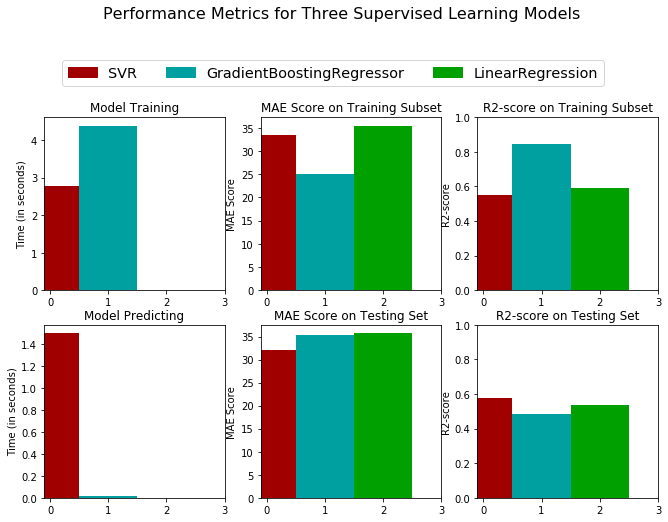

In [131]:
svr = SVR(kernel = 'linear',gamma='scale')
gbr = GBR(n_estimators = 150 )
lr = LR()
results = {}
for clf in [svr, gbr, lr]:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf,X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [132]:
results

{'SVR': {'train_time': 2.770780324935913,
  'pred_time': 1.4972174167633057,
  'mae_train': 33.402424641962696,
  'mae_test': 32.17220595994555,
  'r2_train': 0.5523110661638629,
  'r2_test': 0.5752569098829549},
 'GradientBoostingRegressor': {'train_time': 4.390798568725586,
  'pred_time': 0.013938188552856445,
  'mae_train': 25.02050707742079,
  'mae_test': 35.31512277164854,
  'r2_train': 0.8457299120217932,
  'r2_test': 0.48597641997775987},
 'LinearRegression': {'train_time': 0.015619039535522461,
  'pred_time': 0.0009684562683105469,
  'mae_train': 35.49266860009362,
  'mae_test': 35.74573245752887,
  'r2_train': 0.5914304830729957,
  'r2_test': 0.5349278512139184}}

Since Linear is the best kernel I will use LinearSVR instead.

LinearSVR trained
GradientBoostingRegressor trained
LinearRegression trained


/home/mmahrous/.local/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


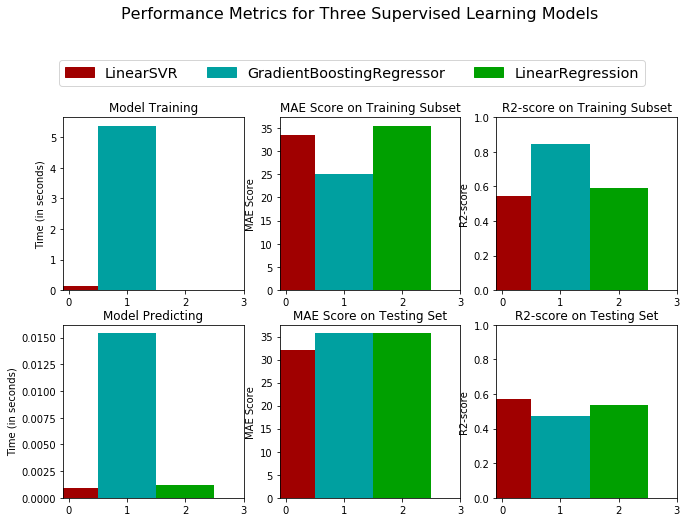

In [133]:
svr = LSVR()
gbr = GBR(n_estimators = 150 )
lr = LR()
results = {}
for clf in [svr, gbr, lr]:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf,X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results)

In [134]:
results

{'LinearSVR': {'train_time': 0.12718534469604492,
  'pred_time': 0.0009031295776367188,
  'mae_train': 33.42861564145836,
  'mae_test': 32.1231570470165,
  'r2_train': 0.5466533950117747,
  'r2_test': 0.5713577138616187},
 'GradientBoostingRegressor': {'train_time': 5.385358095169067,
  'pred_time': 0.01542520523071289,
  'mae_train': 25.02050707742079,
  'mae_test': 35.748153004763985,
  'r2_train': 0.8457299120217932,
  'r2_test': 0.47358388825338005},
 'LinearRegression': {'train_time': 0.020865678787231445,
  'pred_time': 0.0012121200561523438,
  'mae_train': 35.49266860009362,
  'mae_test': 35.74573245752887,
  'r2_train': 0.5914304830729957,
  'r2_test': 0.5349278512139184}}

## 5. Results 

### 5.1 How well can we predict Prices ? 

After tuning the models, we got them all to comparable performance. Now we can asses our modelling. 

Our model has a Mean Absolute Error of $32 which means that we can trust our model price accuracy in the range of about 32 dollars, which is not a strong model. The R2 score is around 0.57 which says that our model is intermediately good.  

Thus, we think that some mode digging in the data is needed to get a better model. My call to action is for natural language processing professionals to analyze the textual data that i ignored to extract important text. Also, analyzing the coordinates and relating them to distances from vital locations can be very helpful. 

### 5.1 What correlates with Prices ? 

In [135]:
top_features = 10

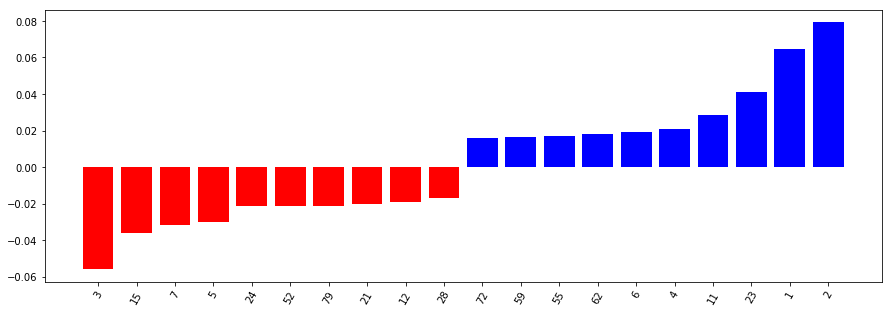

In [136]:
coef = svr.coef_.ravel()
coef /= abs(coef).sum()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
plt.xticks(np.arange(0, 2 * top_features), top_coefficients, rotation=60)
plt.show()

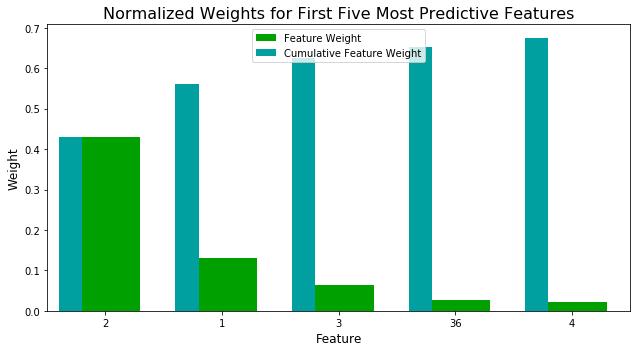

In [137]:
importances = gbr.feature_importances_ 

# Plot
# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = indices
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (9,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)

plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

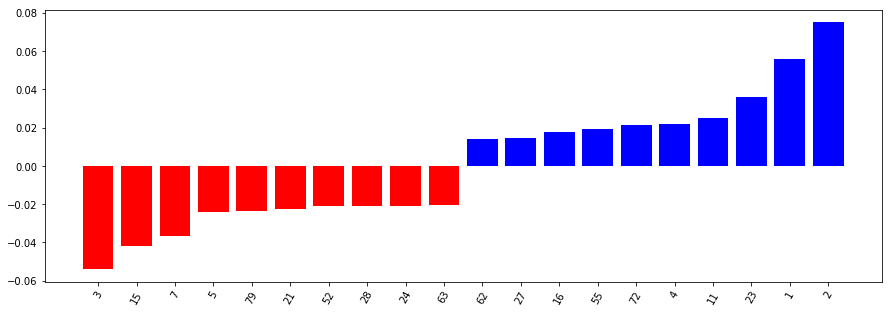

In [138]:
coef = lr.coef_.ravel()
coef /= abs(coef).sum()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
plt.xticks(np.arange(0, 2 * top_features), top_coefficients, rotation=60)
plt.show()

These are weights based on the principle components. 
Next we will try to link those to the original features 

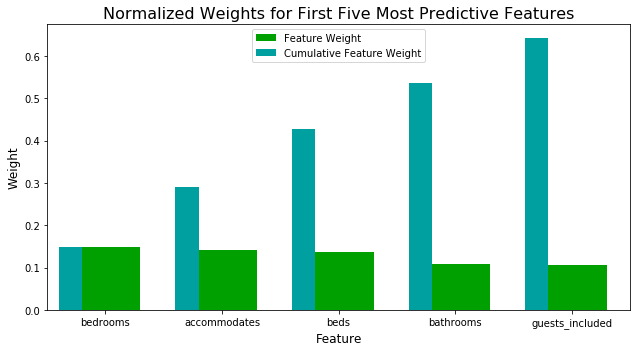

In [141]:
importances = gbr.feature_importances_ 
importances = np.dot(importances.reshape(1,-1),pca.components_).reshape(-1,)
# Plot
# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = np.asarray(s_listings_features_cols)[indices]
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (9,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)

plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

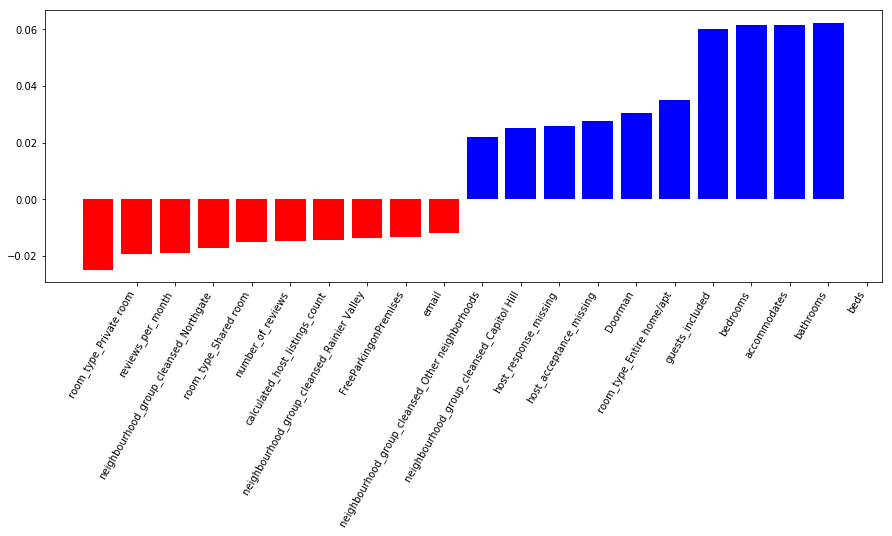

In [142]:
coef = lr.coef_.ravel()
coef /= abs(coef).sum()
coef = np.dot(coef.reshape(1,-1),pca.components_).reshape(-1,)
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
plt.xticks(np.arange(1, 1 + 2 * top_features), np.asarray(s_listings_features_cols)[top_coefficients], rotation=60, ha='right')
# plt.xticks(np.arange(0, 2 * top_features), top_coefficients, rotation=60)
plt.show()

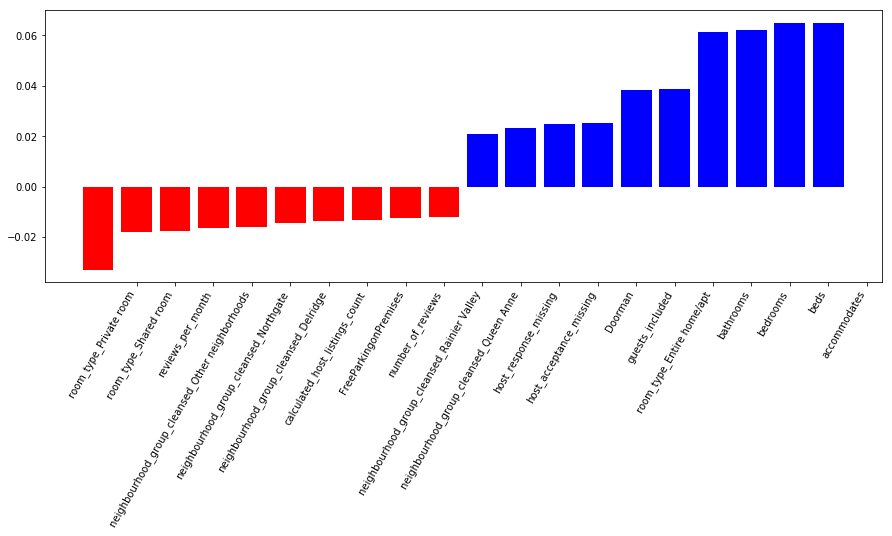

In [143]:
coef = svr.coef_.ravel()
coef /= abs(coef).sum()
coef = np.dot(coef.reshape(1,-1),pca.components_).reshape(-1,)
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
# create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
plt.xticks(np.arange(1, 1 + 2 * top_features), np.asarray(s_listings_features_cols)[top_coefficients], rotation=60, ha='right')
# plt.xticks(np.arange(0, 2 * top_features), top_coefficients, rotation=60)
plt.show()

We find really nteresting and sane results from the previous two graphs. 

There is a positive postive correlation between number of accomadates, beds, bathrooms, bedrooms and guests_included and price. Which is quite sensible. 

This gives insight for people who want to add listings to do their best to make their listings accomodate more people and guests. 

On the other hand, being a private room or a shared room is affiliated with smaller prices which makes sense as other types of apartments are bigger and tend to be more expensive. This idea is confirmed by having room type home/apartment at the top of features correlating to higer prices. 

On the side of neighbourhood, Other neighborhoods, Northgate, Deliridge and Rainer valley are correlating with lower prices while Queen anne has a positive correlation.

Looking at the host attributes, superhosts usually have higher prices. Also, rows that had missing acceptance and response rates are attributed with a higher price which needs some investigation on why that is the case. Having a high response rate is attributed with lower prices, which means that picky hosts usually have higher prices. 

Having a Doorman also is attributed to higher prices. 